# Classification

In this notebook, we will perform the analysis of the function $g(x, y)$ that is 1 if $x>0$ and $y>0$, and 0 otherwise.

## Data Generation and Train-Test-Split

In [1]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


from gradient_descent import GradientDescent
from regression_cost_funcs import LogisticCost
from feedforward_nn import NeuralNetwork
from data_generation import generate_data_binary


sns.set_theme()
sns.set_style("whitegrid")


## SGD Parameters

In [2]:

def gradient_descent_execution(X, w0, z, model, eta = 0.01, mode="normal", n_epochs = 1000):
    batch_size = 10
    momentum = 0.9
    store_extra = True

    gd = GradientDescent(batch_size=batch_size, momentum_param=momentum, store_extra=store_extra, mode=mode)
    w = gd.train(X, w0, z, model, eta, n_epochs)
    return w, gd


## Logistic regression

First, we train our SGD-based logistic regression model.

In [43]:
X, y = generate_data_binary(1000, seed=67)

# Split data into training and test sets
X_TRAIN, X_test, y_TRAIN, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
# Split into validation data and training data
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_TRAIN, test_size=0.2, random_state=22)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_TRAIN = scaler.transform(X_TRAIN)

# Add column of ones to X
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
X_TRAIN = np.hstack((np.ones((X_TRAIN.shape[0], 1)), X_TRAIN))

In [44]:
# Run example gradient descent

# Initialize weights
w0 = np.zeros((X_train.shape[1])).reshape(-1, 1)

# Run gradient descent
model = LogisticCost()
w, gd = gradient_descent_execution(X_train, w0, y_train, model, eta=0.01, mode="normal", n_epochs=1000)

prediction score:  0.9125


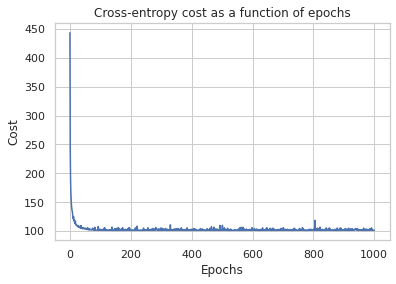

In [45]:
print("prediction score: ", accuracy_score(y_val, model.predict_class(X_val, w)))

plt.plot(gd.costs)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cross-entropy cost as a function of epochs")
plt.show()

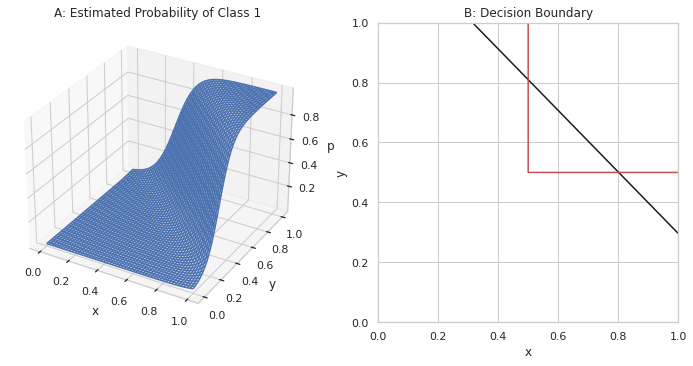

In [46]:
# Plot probability of predicting class 1
xx, yy = np.meshgrid(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000))
xx_f, yy_f = xx.flatten(), yy.flatten()
grid_size = xx_f.size
X_grid = np.vstack((np.ones(grid_size), xx_f, yy_f)).T
z_grid = model.predict(X_grid, w)
z_grid = z_grid.reshape(xx.shape)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(xx, yy, z_grid)
ax.set_title("A: Estimated Probability of Class 1")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p')

# Plot decision boundary
ax = fig.add_subplot(122)
ax.contour(xx, yy, z_grid, levels=[0.5], colors='k')
ax.set_title("B: Decision Boundary")
ax.set_xlabel('x')
ax.set_ylabel('y')


# Plot true classification cut-off
true_z = np.zeros((grid_size))
# Plot true function
for i, (xx_i, yy_i) in enumerate(zip(xx_f, yy_f)):
    if  xx_i > 0.5 and yy_i > 0.5:
        true_z[i] = 1

true_z = true_z.reshape(xx.shape)
ax.contour(xx, yy, true_z, levels=[0.5], colors='r')
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

In [47]:
lambdas = np.concatenate([np.array([0.]), np.logspace(-5, 1, 7)])
etas = np.logspace(-4, 0, 5)
n = lambdas.size
m = etas.size
train_scores = np.zeros((n, m))
n_averages = 10

for i, lmbda in enumerate(lambdas):
    for j, eta in enumerate(etas):
        # Run gradient descent
        model = LogisticCost(regularization=lmbda)
        w, gd = gradient_descent_execution(X_train, w0, y_train, model, eta=eta, mode="normal", n_epochs=1000)
        for _ in range(n_averages):
            train_scores[i, j] += accuracy_score(y_val, model.predict_class(X_val, w))

train_scores /= n_averages




/home/carlfre/FYS-STK3155-project-2/regression_cost_funcs.py:163: RuntimeWarning: overflow encountered in square
  return - np.sum(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps)) + self.regularization * np.sum(w[1:] ** 2)
/home/carlfre/FYS-STK3155-project-2/regression_cost_funcs.py:169: RuntimeWarning: overflow encountered in multiply
  reg = 2 * self.regularization * w
/home/carlfre/FYS-STK3155-project-2/gradient_descent.py:108: RuntimeWarning: invalid value encountered in subtract
  return self.momentum * self.momentum_param - eta * model.gradient(X, w, y)


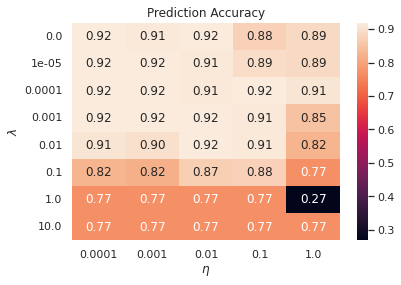

In [48]:
sns.heatmap(train_scores, annot=True, fmt=".2f", xticklabels=etas, yticklabels=lambdas)
plt.title("Prediction Accuracy")
xlabel = plt.xlabel("$\eta$")
ylabel = plt.ylabel("$\lambda$")
plt.show()


Next, we repeatedly train the model on the full training data with $\eta = 0.001$ and $\lambda = 0$ as our choice of model. We estimate the expected accuracy score.

In [49]:
n_averages = 100
accuracy_scores = []
for _ in range(n_averages):
    model = LogisticCost()
    w, gd = gradient_descent_execution(X_TRAIN, w0, y_TRAIN, model, eta=eta, mode="normal", n_epochs=1000)
    accuracy_scores.append(accuracy_score(y_test, model.predict_class(X_test, w)))

print("Mean accuracy score: ", np.mean(accuracy_scores))

Mean accuracy score:  0.8758000000000001


We see that the mean accuracy score when sdg is initalized from these conditions is 0.875

Next, we run sklearns logistic regression to compare with our results

In [50]:
model = LogisticRegression()
model.fit(X_TRAIN, y_TRAIN.ravel())
print("sklearn accuracy score: ", accuracy_score(y_test.ravel(), model.predict(X_test)))


sklearn accuracy score:  0.89


This accuracy score is slightly higher. This could be due to difference in solver or momentum parameter, or simply randomness

## Neural Network Approximations

In [3]:
X, y = generate_data_binary(1000, seed=67)

# Split data into training and test sets
X_TRAIN, X_test, y_TRAIN, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
# Split into validation data and training data
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_TRAIN, test_size=0.2, random_state=22)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_TRAIN = scaler.transform(X_TRAIN)


In [4]:
layers = [2, 4, 4, 4, 1]
activation = "relu"
output_activation = "sigmoid"
cost_function = "cross_entropy"
regularization = 0.0

n_averages = 100
accuracy_scores_nn = []
for _ in range(n_averages):
    model = NeuralNetwork(
        layers, 
        activation=activation, 
        output_activation=output_activation, 
        cost_function=cost_function, 
        regularization=regularization
        )

    wb = model.wb()

    # Run gradient descent
    w, gd = gradient_descent_execution(X_train, wb, y_train, model, eta=0.01, mode="normal", n_epochs=500)
    accuracy_scores_nn.append(accuracy_score(y_val, model.predict_class(X_val, w)))


KeyboardInterrupt: 

In [128]:
print("Mean accuracy score: ", np.mean(accuracy_scores_nn))

Mean accuracy score:  0.9535000000000001


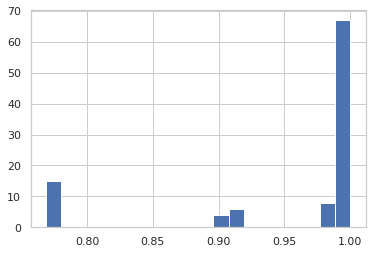

In [129]:
plt.hist(accuracy_scores_nn, bins=20, label="Logistic Regression")
plt.show()

We see that more than half the neural networks learn a near-perfect representation of the function. The other networks appear to get stuck in local minima (eg. predicting a constant function)

In [130]:
print(len(accuracy_scores_nn))
print(len([x for x in accuracy_scores_nn if x > 0.98]))

100
75


In [6]:
model = NeuralNetwork(
    layers, 
    activation=activation, 
    output_activation=output_activation, 
    cost_function=cost_function, 
    regularization=regularization
    )

wb = model.wb()

# Run gradient descent
w1, gd1 = gradient_descent_execution(X_train, wb, y_train, model, eta=0.01, mode="normal", n_epochs=500)



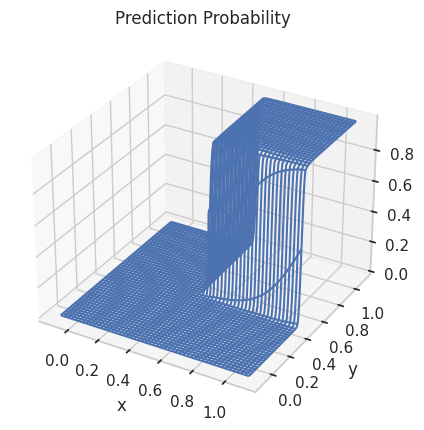

In [7]:
# plot the prediction on the grid
xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, 1000), np.linspace(-0.1, 1.1, 1000))
xx_f = xx.flatten()
yy_f = yy.flatten()
X_grid = np.vstack([xx_f, yy_f]).T
z_grid = model.predict(X_grid, w1).reshape(xx.shape)

# Plot decision boundary
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(xx, yy, z_grid)
ax.set_title("Prediction Probability")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p')
plt.show()

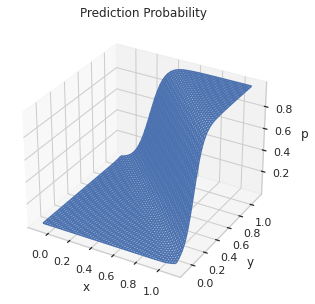

In [137]:
model = NeuralNetwork(
    layers, 
    activation=activation, 
    output_activation=output_activation, 
    cost_function=cost_function, 
    regularization=regularization
    )

wb = model.wb()

# Run gradient descent
w2, gd2 = gradient_descent_execution(X_train, wb, y_train, model, eta=0.01, mode="normal", n_epochs=500)

# plot the prediction on the grid
xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, 1000), np.linspace(-0.1, 1.1, 1000))
xx_f = xx.flatten()
yy_f = yy.flatten()
X_grid = np.vstack([xx_f, yy_f]).T
z_grid = model.predict(X_grid, w2).reshape(xx.shape)

# Plot decision boundary
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(xx, yy, z_grid)
ax.set_title("Prediction Probability")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p')
plt.show()

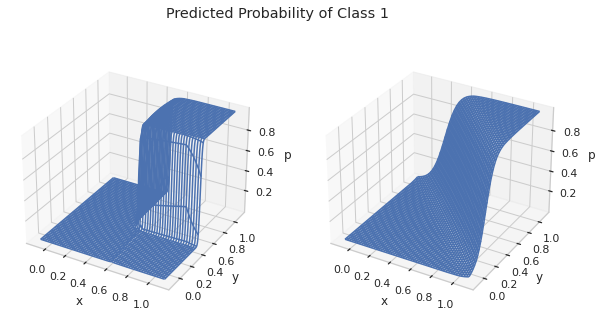

In [145]:
xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, 1000), np.linspace(-0.1, 1.1, 1000))
xx_f = xx.flatten()
yy_f = yy.flatten()
X_grid = np.vstack([xx_f, yy_f]).T
z1_grid = model.predict(X_grid, w1).reshape(xx.shape)
z2_grid = model.predict(X_grid, w2).reshape(xx.shape)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(xx, yy, z1_grid)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p')

ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(xx, yy, z2_grid)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('p')

fig.suptitle("Predicted Probability of Class 1")

plt.show()

In [9]:
# Run gridsearch for best set of eta and lambda
etas = [0.0001, 0.001, 0.01, 0.1, 1.0]
lambdas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

n_averages = 50
train_scores = np.zeros((len(etas), len(lambdas)))
val_scores = np.zeros((len(etas), len(lambdas)))
for i, eta in tqdm(enumerate(etas)):
    for j, lmbda in enumerate(lambdas):
        train_accuracy_scores = []
        val_accuracy_scores = []
        for _ in range(n_averages):
            model = NeuralNetwork(
                layers, 
                activation=activation, 
                output_activation=output_activation, 
                cost_function=cost_function, 
                regularization=lmbda
                )

            wb = model.wb()

            # Run gradient descent
            w, gd = gradient_descent_execution(X_train, wb, y_train, model, eta=eta, mode="normal", n_epochs=500)
            train_accuracy_scores.append(accuracy_score(y_train, model.predict_class(X_train, w)))
            val_accuracy_scores.append(accuracy_score(y_val, model.predict_class(X_val, w)))

        train_scores[i, j] = np.mean(train_accuracy_scores)
        val_scores[i, j] = np.mean(val_accuracy_scores)

3it [3:16:29, 3945.19s/it]/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn

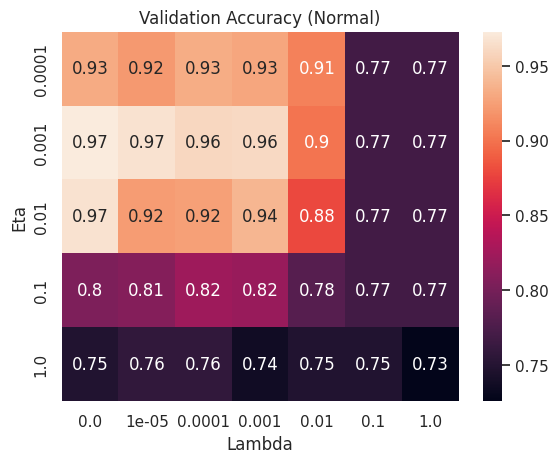

In [10]:
sns.heatmap(val_scores, annot=True, xticklabels=lambdas, yticklabels=etas)
plt.xlabel("Lambda")
plt.ylabel("Eta")
plt.title("Validation Accuracy (Normal)")
plt.show()


In [11]:
# Run gridsearch for best set of eta and lambda
etas = [0.0001, 0.001, 0.01, 0.1, 1.0]
lambdas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

n_averages = 50
train_scores = np.zeros((len(etas), len(lambdas)))
val_scores = np.zeros((len(etas), len(lambdas)))
for i, eta in tqdm(enumerate(etas)):
    for j, lmbda in enumerate(lambdas):
        train_accuracy_scores = []
        val_accuracy_scores = []
        for _ in range(n_averages):
            model = NeuralNetwork(
                layers, 
                activation=activation, 
                output_activation=output_activation, 
                cost_function=cost_function, 
                regularization=lmbda
                )

            wb = model.wb()

            # Run gradient descent
            w, gd = gradient_descent_execution(X_train, wb, y_train, model, eta=eta, mode="adagrad", n_epochs=500)
            train_accuracy_scores.append(accuracy_score(y_train, model.predict_class(X_train, w)))
            val_accuracy_scores.append(accuracy_score(y_val, model.predict_class(X_val, w)))

        train_scores[i, j] = np.mean(train_accuracy_scores)
        val_scores[i, j] = np.mean(val_accuracy_scores)

4it [7:53:42, 7131.34s/it]/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
5it [9:53:06, 7117.28s/it]


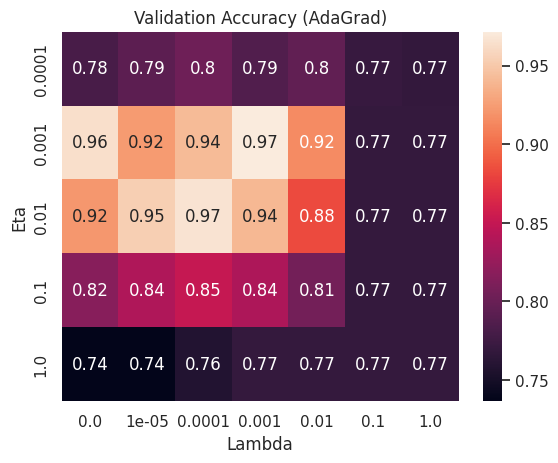

In [12]:
sns.heatmap(val_scores, annot=True, xticklabels=lambdas, yticklabels=etas)
plt.xlabel("Lambda")
plt.ylabel("Eta")
plt.title("Validation Accuracy (AdaGrad)")
plt.show()


In [13]:
# Run gridsearch for best set of eta and lambda
etas = [0.0001, 0.001, 0.01, 0.1, 1.0]
lambdas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

n_averages = 50
train_scores = np.zeros((len(etas), len(lambdas)))
val_scores = np.zeros((len(etas), len(lambdas)))
for i, eta in tqdm(enumerate(etas)):
    for j, lmbda in enumerate(lambdas):
        train_accuracy_scores = []
        val_accuracy_scores = []
        for _ in range(n_averages):
            model = NeuralNetwork(
                layers, 
                activation=activation, 
                output_activation=output_activation, 
                cost_function=cost_function, 
                regularization=lmbda
                )

            wb = model.wb()

            # Run gradient descent
            w, gd = gradient_descent_execution(X_train, wb, y_train, model, eta=eta, mode="adam", n_epochs=500)
            train_accuracy_scores.append(accuracy_score(y_train, model.predict_class(X_train, w)))
            val_accuracy_scores.append(accuracy_score(y_val, model.predict_class(X_val, w)))

        train_scores[i, j] = np.mean(train_accuracy_scores)
        val_scores[i, j] = np.mean(val_accuracy_scores)

3it [3:13:07, 3856.42s/it]/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn

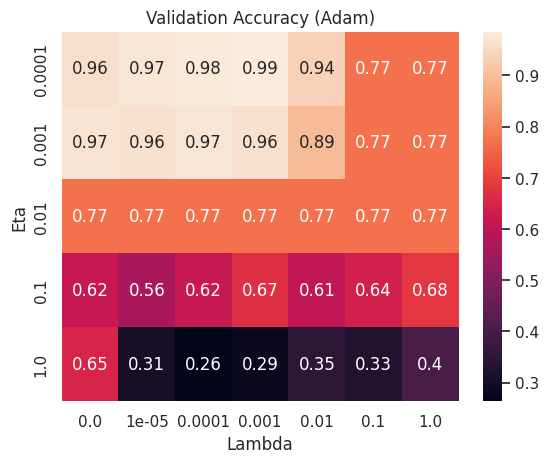

In [14]:
sns.heatmap(val_scores, annot=True, xticklabels=lambdas, yticklabels=etas)
plt.xlabel("Lambda")
plt.ylabel("Eta")
plt.title("Validation Accuracy (Adam)")
plt.show()


In [15]:
# Run gridsearch for best set of eta and lambda
etas = [0.0001, 0.001, 0.01, 0.1, 1.0]
lambdas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

n_averages = 50
train_scores = np.zeros((len(etas), len(lambdas)))
val_scores = np.zeros((len(etas), len(lambdas)))
for i, eta in tqdm(enumerate(etas)):
    for j, lmbda in enumerate(lambdas):
        train_accuracy_scores = []
        val_accuracy_scores = []
        for _ in range(n_averages):
            model = NeuralNetwork(
                layers, 
                activation=activation, 
                output_activation=output_activation, 
                cost_function=cost_function, 
                regularization=lmbda
                )

            wb = model.wb()

            # Run gradient descent
            w, gd = gradient_descent_execution(X_train, wb, y_train, model, eta=eta, mode="rmsprop", n_epochs=500)
            train_accuracy_scores.append(accuracy_score(y_train, model.predict_class(X_train, w)))
            val_accuracy_scores.append(accuracy_score(y_val, model.predict_class(X_val, w)))

        train_scores[i, j] = np.mean(train_accuracy_scores)
        val_scores[i, j] = np.mean(val_accuracy_scores)

2it [4:28:40, 7984.07s/it]/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/home/carlfre/FYS-STK3155-project-2/feedforward_nn

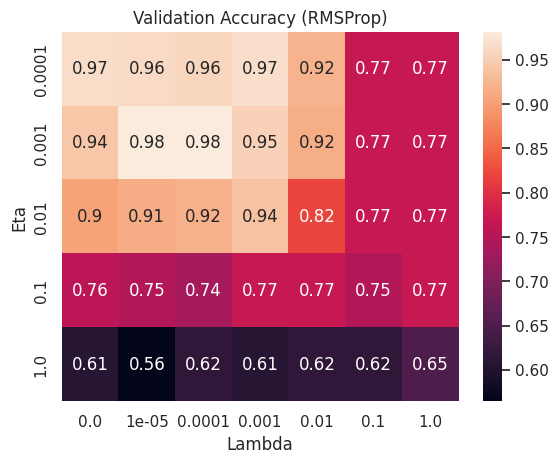

In [16]:
sns.heatmap(val_scores, annot=True, xticklabels=lambdas, yticklabels=etas)
plt.xlabel("Lambda")
plt.ylabel("Eta")
plt.title("Validation Accuracy (RMSProp)")
plt.show()
